In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from njit_funcs_recursive_grid import *
from backtest import backtest
from plotting import plot_fills, make_table
from downloader import Downloader, load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba
using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [4]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/myconfig_v02.hjson"
        self.exchange = "bitget"
        self.symbols = "TRBUSDT"
        self.market_type = "futures"
        self.user = "bitget_01"
        self.start_date = "2023-10-13"
        self.end_date = "2023-10-16"
        self.starting_balance = 1000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = "y"  # set to "n" to use 1s candles


config = prepare_backtest_config(Args())

config["adg_n_subdivisions"] = 20  # see configs/backtest/default.hjson for details
config["inverse"] = False
sts = time()
if config["ohlcv"]:
    data = await load_hlc_cache(
        config["symbol"],
        config["inverse"],
        config["start_date"],
        config["end_date"],
        base_dir=config["base_dir"],
        spot=config["spot"],
        exchange=config["exchange"],
    )
    prices = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    closes = data[:, 3]
else:
    downloader = Downloader(config)
    data = await downloader.get_sampled_ticks()
    prices = data[:, 2]
    highs = data[:, 2]
    lows = data[:, 2]
    closes = data[:, 2]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings for TRBUSDT...
TRBUSDT most n days of consecutive identical ohlcvs: 0.000, index last: 0
millis to load 4320 ticks 1ms


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

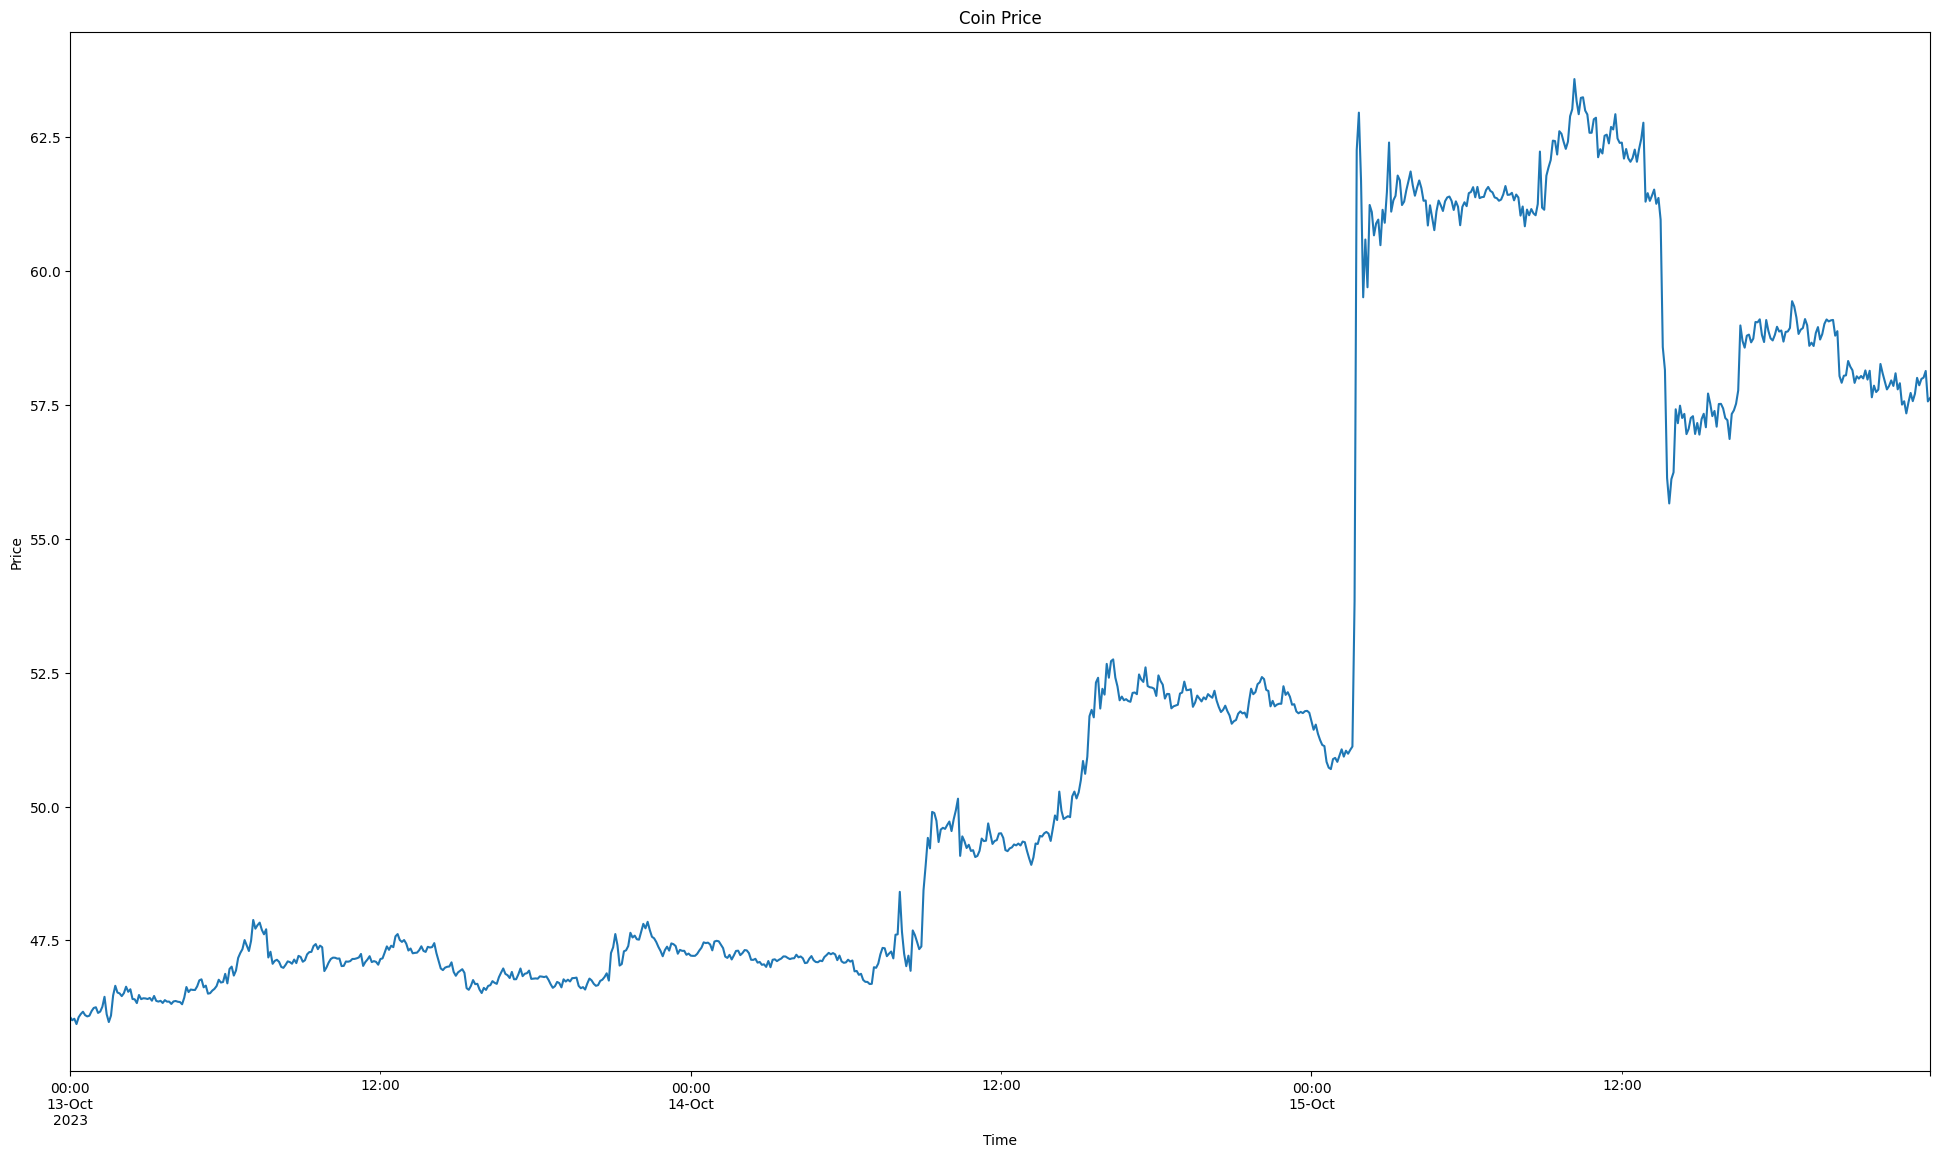

In [52]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df2 = pd.DataFrame({"timestamp": pd.to_datetime(timestamps, unit='ms'), "price": prices}).set_index("timestamp")
df2.price.iloc[::5].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [14]:
# choose a slice on which to test
wsize_days = 3650
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]
len(dataslice)

4320

In [15]:
custom_tuned = {
    "long":
        {
            "auto_unstuck_ema_dist": -0.03873483086285913,
            "auto_unstuck_wallet_exposure_threshold": 0.05913245621339072,
            "backwards_tp": True,
            "ddown_factor": 0.9663971682907846,
            "ema_span_0": 978.9440265702858,
            "ema_span_1": 1173.5898790671702,
            "enabled": True,
            "initial_eprice_ema_dist": 0.004,
            "initial_qty_pct": 0.02446427054013184,
            "markup_range": 0.01,
            "min_markup": 0.008540442504828518,
            "n_close_orders": 4.138115775049637,
            "rentry_pprice_dist": 0.030052654239696483,
            "rentry_pprice_dist_wallet_exposure_weighting": 11.18830873089761,
            "wallet_exposure_limit": 3
        },
    "short":
        {
            "auto_unstuck_ema_dist": 0.003,
            "auto_unstuck_wallet_exposure_threshold": 0.03614448454100035,
            "backwards_tp": True,
            "ddown_factor": 0.5909176560534417,
            "ema_span_0": 465.9268827189821,
            "ema_span_1": 623.1580630663296,
            "enabled": True,
            "initial_eprice_ema_dist": -0.0014719870386391079,
            "initial_qty_pct": 0.07142909087153279,
            "markup_range": 0.010541365857953094,
            "min_markup": 0.005403811055924777,
            "n_close_orders": 8.404989017720261,
            "rentry_pprice_dist": 0.024450503837829943,
            "rentry_pprice_dist_wallet_exposure_weighting": 4.358998913087744,
            "wallet_exposure_limit": 3
        }
}

In [16]:
hand_tuned = {
    "long":
        {
            "auto_unstuck_delay_minutes": 1000.0,
            "auto_unstuck_ema_dist": 0.001,
            "auto_unstuck_qty_pct": 0.04,
            "auto_unstuck_wallet_exposure_threshold": 0.15,
            "backwards_tp": True,
            "ddown_factor": 0.6,
            "ema_span_0": 700,
            "ema_span_1": 1440,
            "enabled": True,
            "initial_eprice_ema_dist": -0.02,
            "initial_qty_pct": 0.01,
            "markup_range": 0.018,
            "min_markup": 0.002,
            "n_close_orders": 16,
            "rentry_pprice_dist": 0.015,
            "rentry_pprice_dist_wallet_exposure_weighting": 15,
            "wallet_exposure_limit": 1.0
        },
    "short":
        {
            "auto_unstuck_delay_minutes": 1000.0,
            "auto_unstuck_ema_dist": 0.001,
            "auto_unstuck_qty_pct": 0.04,
            "auto_unstuck_wallet_exposure_threshold": 0.05,
            "backwards_tp": True,
            "ddown_factor": 0.19,
            "ema_span_0": 1440,
            "ema_span_1": 2880,
            "enabled": True,
            "initial_eprice_ema_dist": 0.02,
            "initial_qty_pct": 0.01,
            "markup_range": 0.018,
            "min_markup": 0.002,
            "n_close_orders": 16,
            "rentry_pprice_dist": 0.015,
            "rentry_pprice_dist_wallet_exposure_weighting": 23,
            "wallet_exposure_limit": 1.0
        }
}


In [19]:
all_keys = sorted(list(
    set(list(custom_tuned["long"].keys()) + list(custom_tuned["short"].keys()) + list(hand_tuned["long"].keys()) + list(
        hand_tuned["short"].keys()))))
all_keys

['auto_unstuck_delay_minutes',
 'auto_unstuck_ema_dist',
 'auto_unstuck_qty_pct',
 'auto_unstuck_wallet_exposure_threshold',
 'backwards_tp',
 'ddown_factor',
 'ema_span_0',
 'ema_span_1',
 'enabled',
 'initial_eprice_ema_dist',
 'initial_qty_pct',
 'markup_range',
 'min_markup',
 'n_close_orders',
 'rentry_pprice_dist',
 'rentry_pprice_dist_wallet_exposure_weighting',
 'wallet_exposure_limit']

In [24]:
params_df = pd.concat(
    [
        pd.DataFrame({k + "_01": v for k, v in custom_tuned.items()}, index=all_keys),
        pd.DataFrame({k + "_01": v for k, v in hand_tuned.items()}, index=all_keys)
    ],
    axis=1
)
params_df

,long_01,short_01,long_01,short_01
auto_unstuck_delay_minutes,NaN,NaN,1000.0,1000.0
auto_unstuck_ema_dist,-0.0387348309,0.003,0.001,0.001
auto_unstuck_qty_pct,NaN,NaN,0.04,0.04
auto_unstuck_wallet_exposure_threshold,0.0591324562,0.0361444845,0.15,0.05
backwards_tp,True,True,True,True
ddown_factor,0.9663971683,0.5909176561,0.6,0.19
ema_span_0,978.9440265703,465.926882719,700,1440
ema_span_1,1173.5898790672,623.1580630663,1440,2880
enabled,True,True,True,True
initial_eprice_ema_dist,0.004,-0.001471987,-0.02,0.02


In [26]:
custom_tuned_filled = {k: {k1: v.get(k1) for k1 in all_keys} for k, v in custom_tuned.items()}
custom_tuned_filled

{'long': {'auto_unstuck_delay_minutes': None,
  'auto_unstuck_ema_dist': -0.03873483086285913,
  'auto_unstuck_qty_pct': None,
  'auto_unstuck_wallet_exposure_threshold': 0.05913245621339072,
  'backwards_tp': True,
  'ddown_factor': 0.9663971682907846,
  'ema_span_0': 978.9440265702858,
  'ema_span_1': 1173.5898790671702,
  'enabled': True,
  'initial_eprice_ema_dist': 0.004,
  'initial_qty_pct': 0.02446427054013184,
  'markup_range': 0.01,
  'min_markup': 0.008540442504828518,
  'n_close_orders': 4.138115775049637,
  'rentry_pprice_dist': 0.030052654239696483,
  'rentry_pprice_dist_wallet_exposure_weighting': 11.18830873089761,
  'wallet_exposure_limit': 3},
 'short': {'auto_unstuck_delay_minutes': None,
  'auto_unstuck_ema_dist': 0.003,
  'auto_unstuck_qty_pct': None,
  'auto_unstuck_wallet_exposure_threshold': 0.03614448454100035,
  'backwards_tp': True,
  'ddown_factor': 0.5909176560534417,
  'ema_span_0': 465.9268827189821,
  'ema_span_1': 623.1580630663296,
  'enabled': True,
  

In [35]:
custom_tuned_filled_2 = {
    'long': {
        'auto_unstuck_delay_minutes': 90000,
        'auto_unstuck_ema_dist': -0.03873483086285913,
        'auto_unstuck_qty_pct': 0.99,
        'auto_unstuck_wallet_exposure_threshold': 0.05913245621339072,
        'backwards_tp': True,
        'ddown_factor': 0.9663971682907846,
        'ema_span_0': 978.9440265702858,
        'ema_span_1': 1173.5898790671702,
        'enabled': True,
        'initial_eprice_ema_dist': 0.004,
        'initial_qty_pct': 0.02446427054013184,
        'markup_range': 0.01,
        'min_markup': 0.008540442504828518,
        'n_close_orders': 4.138115775049637,
        'rentry_pprice_dist': 0.030052654239696483,
        'rentry_pprice_dist_wallet_exposure_weighting': 11.18830873089761,
        'wallet_exposure_limit': 3},
    'short': {
        'auto_unstuck_delay_minutes': 90000,
        'auto_unstuck_ema_dist': 0.003,
        'auto_unstuck_qty_pct': 0.99,
        'auto_unstuck_wallet_exposure_threshold': 0.03614448454100035,
        'backwards_tp': True,
        'ddown_factor': 0.5909176560534417,
        'ema_span_0': 465.9268827189821,
        'ema_span_1': 623.1580630663296,
        'enabled': True,
        'initial_eprice_ema_dist': -0.0014719870386391079,
        'initial_qty_pct': 0.07142909087153279,
        'markup_range': 0.010541365857953094,
        'min_markup': 0.005403811055924777,
        'n_close_orders': 8.404989017720261,
        'rentry_pprice_dist': 0.024450503837829943,
        'rentry_pprice_dist_wallet_exposure_weighting': 4.358998913087744,
        'wallet_exposure_limit': 3
    }
}

In [36]:
config_to_test = {**config, **custom_tuned_filled_2}
# config_to_test = {**config, **custom_tuned_filled}


Grid Span Long = 37.10%
Grid Span Short = 17.04%


,qty,price,type,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
5,-17.40,67.608,short_rentry,-46.78,64.1290183839,2.99995548,0.0514581354,0.5922396188,85.5056750748
4,-10.91,64.517,short_rentry,-29.38,62.0686276378,1.82357628,0.0379492593,0.5906876015,96.1053873383
3,-6.86,62.457,short_rentry,-18.47,60.6224044396,1.11969581,0.0293737381,0.5908699397,114.7642560910
2,-4.31,61.002,short_rentry,-11.61,59.5383970715,0.69124079,0.0239927040,0.5904109589,145.6710413437
1,-3.59,59.616,short_rentry,-7.30,58.6742698630,0.42832217,0.0157966005,0.9676549865,195.6605712329
0,-3.71,57.763,short_ientry_normal,-3.71,57.7630000000,0.21430073,0.0000000000,NaN,327.3047789757
0,1.28,57.531,long_ientry_normal,1.28,57.5310000000,0.07363968,0.0000000000,NaN,0.0000000000
1,1.33,55.327,long_rentry,2.61,56.4078888889,0.14722459,0.0195363726,1.0390625000,0.0000000000
2,2.52,53.781,long_rentry,5.13,55.1174873294,0.28275271,0.0248505481,0.9655172414,0.0000000000
3,4.96,51.714,long_rentry,10.09,53.4444152626,0.53925415,0.0334612535,0.9668615984,0.0000000000


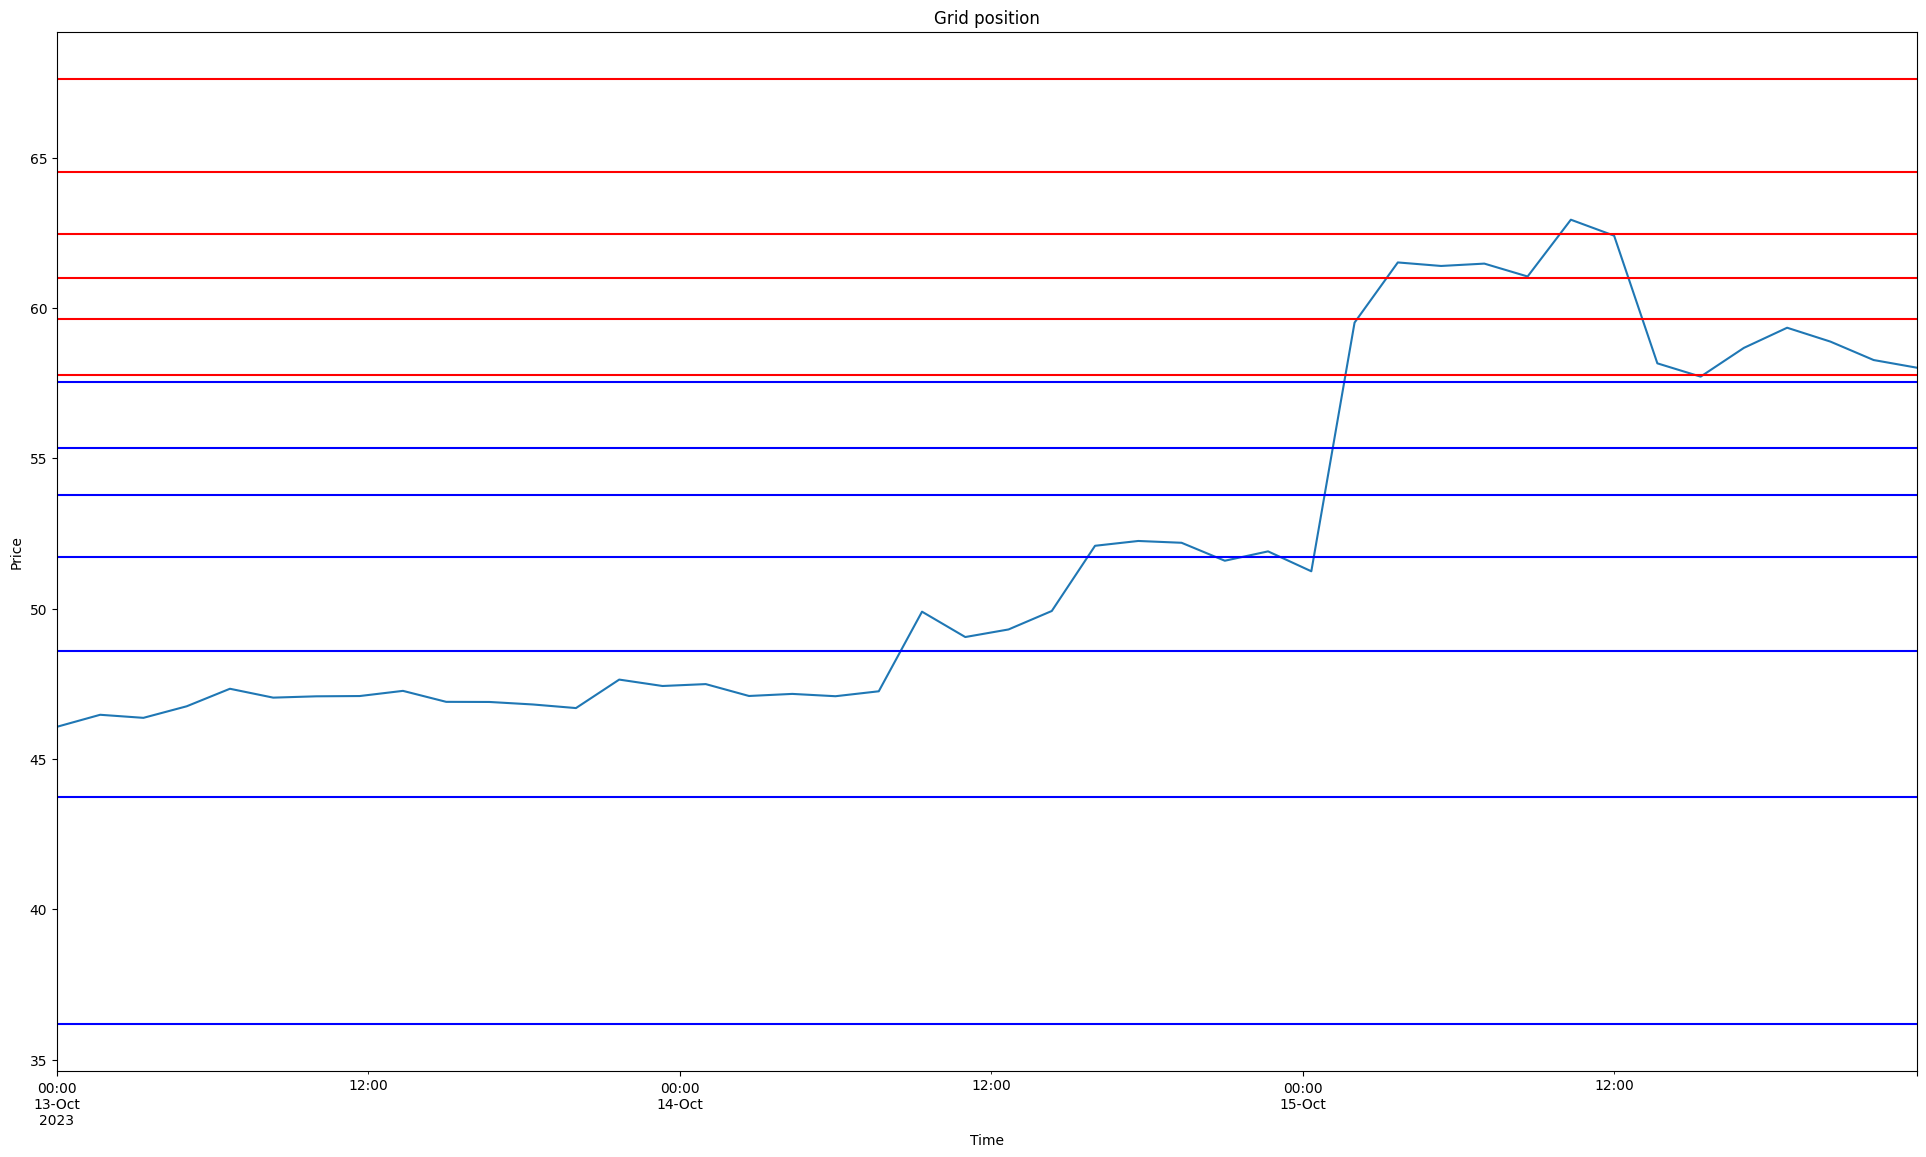

In [53]:
grid_long = calc_recursive_entries_long(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["long"]["initial_qty_pct"],
    config_to_test["long"]["initial_eprice_ema_dist"],
    config_to_test["long"]["ddown_factor"],
    config_to_test["long"]["rentry_pprice_dist"],
    config_to_test["long"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["long"]["wallet_exposure_limit"],
    config_to_test["long"]["auto_unstuck_ema_dist"],
    config_to_test["long"]["auto_unstuck_wallet_exposure_threshold"],
    config_to_test["long"]["auto_unstuck_delay_minutes"]
    or config_to_test["long"]["auto_unstuck_qty_pct"],
    whole_grid=True,
)

grid_short = calc_recursive_entries_short(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["short"]["initial_qty_pct"],
    config_to_test["short"]["initial_eprice_ema_dist"],
    config_to_test["short"]["ddown_factor"],
    config_to_test["short"]["rentry_pprice_dist"],
    config_to_test["short"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["short"]["wallet_exposure_limit"],
    config_to_test["short"]["auto_unstuck_ema_dist"],
    config_to_test["short"]["auto_unstuck_wallet_exposure_threshold"],
    config_to_test["short"]["auto_unstuck_delay_minutes"]
    or config_to_test["short"]["auto_unstuck_qty_pct"],
    whole_grid=True,
)

gdf_long = pd.DataFrame(
    grid_long, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_long.loc[:, "eprice_pprice_diff"] = abs(gdf_long.price - gdf_long.pprice) / gdf_long.price
gdf_long.loc[:, "ddown_factor"] = gdf_long.qty / gdf_long.psize.shift()
gdf_long.loc[:, "bkr_price"] = gdf_long.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)
gdf_short = pd.DataFrame(
    grid_short, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_short.loc[:, "eprice_pprice_diff"] = abs(gdf_short.price - gdf_short.pprice) / gdf_short.price
gdf_short.loc[:, "ddown_factor"] = gdf_short.qty / gdf_short.psize.shift()
gdf_short.loc[:, "bkr_price"] = gdf_short.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)

# Display grid on graph
n_ticks = 60 * 60 * 24 * 14  # 14 days
dfx = pd.DataFrame(
    {
        "timestamp": pd.to_datetime(timestamps[-n_ticks:], unit="ms"),
        "price": prices[-n_ticks:],
    }
).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
fig = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=180): lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
if config_to_test["long"]["enabled"]:
    for i, e in enumerate(gdf_long.itertuples()):
        fig.axhline(y=e.price, color="b", linestyle="-")
    print(f"\nGrid Span Long = {-(gdf_long.price.iloc[-1] / gdf_long.price.iloc[0] - 1) * 100:.2f}%")

if config_to_test["short"]["enabled"]:
    for i, e in enumerate(gdf_short.itertuples()):
        fig.axhline(y=e.price, color="r", linestyle="-")
    print(f"Grid Span Short = {(gdf_short.price.iloc[-1] / gdf_short.price.iloc[0] - 1) * 100:.2f}%")

pd.concat([gdf_long, gdf_short]).sort_values("price", ascending=False)

In [38]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
table = make_table({**config_to_test, **analysis})
print(table)

seconds elapsed 28.4058
+-----------------------------------------------------+
|                       Summary                       |
+----------------------------------------+------------+
| Metric                                 | Value      |
+----------------------------------------+------------+
| Exchange                               | bitget     |
| Market type                            | futures    |
| Symbol                                 | TRBUSDT    |
| Passivbot mode                         | unknown    |
| ADG n subdivisions                     | 20         |
| No. days                               | 3.0        |
| Starting balance                       | 1000.0     |
|                                        |            |
| Long                                   | True       |
| ADG per exposure                       | 0.0899%    |
| ADG weighted per exposure              | 0.0877%    |
| Final balance                          | 1008.0     |
| Final equity          

In [42]:
sdf["time"] = pd.to_datetime(sdf["timestamp"], unit="ms")
sdf

,timestamp,bkr_price_long,bkr_price_short,psize_long,pprice_long,psize_short,pprice_short,price,closest_bkr_long,closest_bkr_short,balance_long,balance_short,equity_long,equity_short,wallet_exposure_long,wallet_exposure_short,time
0,1697155260000.0,0.0,0.0000000000,0.00,0.000,0.00,0.000,46.026,1.0,1.0000000000,1000.000000000,1000.000000000,1000.000000000,1000.000000000,0.0000000000,0.000000000,2023-10-13 00:01:00
1,1697158860000.0,0.0,0.0000000000,0.00,0.000,0.00,0.000,46.196,1.0,1.0000000000,1000.000000000,1000.000000000,1000.000000000,1000.000000000,0.0000000000,0.000000000,2023-10-13 01:01:00
2,1697162460000.0,0.0,0.0000000000,0.00,0.000,0.00,0.000,46.517,1.0,1.0000000000,1000.000000000,1000.000000000,1000.000000000,1000.000000000,0.0000000000,0.000000000,2023-10-13 02:01:00
3,1697166060000.0,0.0,0.0000000000,0.00,0.000,0.00,0.000,46.413,1.0,1.0000000000,1000.000000000,1000.000000000,1000.000000000,1000.000000000,0.0000000000,0.000000000,2023-10-13 03:01:00
4,1697169660000.0,0.0,0.0000000000,0.00,0.000,0.00,0.000,46.291,1.0,1.0000000000,1000.000000000,1000.000000000,1000.000000000,1000.000000000,0.0000000000,0.000000000,2023-10-13 04:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1697396460000.0,0.0,335.9785696235,0.00,57.723,-2.21,59.194,59.040,1.0,0.0845885303,1008.015733394,611.693898868,1008.015733394,612.034238868,0.0000000000,0.213863078,2023-10-15 19:01:00
68,1697400060000.0,0.0,335.9785696235,0.00,57.723,-2.21,59.194,59.155,1.0,0.0845885303,1008.015733394,611.693898868,1008.015733394,611.780088868,0.0000000000,0.213863078,2023-10-15 20:01:00
69,1697403660000.0,0.0,0.0000000000,1.27,58.176,0.00,59.194,57.993,1.0,0.0845885303,1008.000956690,613.754392368,1007.768546690,613.754392368,0.0732970733,0.000000000,2023-10-15 21:01:00
70,1697407260000.0,0.0,0.0000000000,1.27,58.176,0.00,59.194,58.229,1.0,0.0845885303,1008.000956690,613.754392368,1008.068266690,613.754392368,0.0732970733,0.000000000,2023-10-15 22:01:00


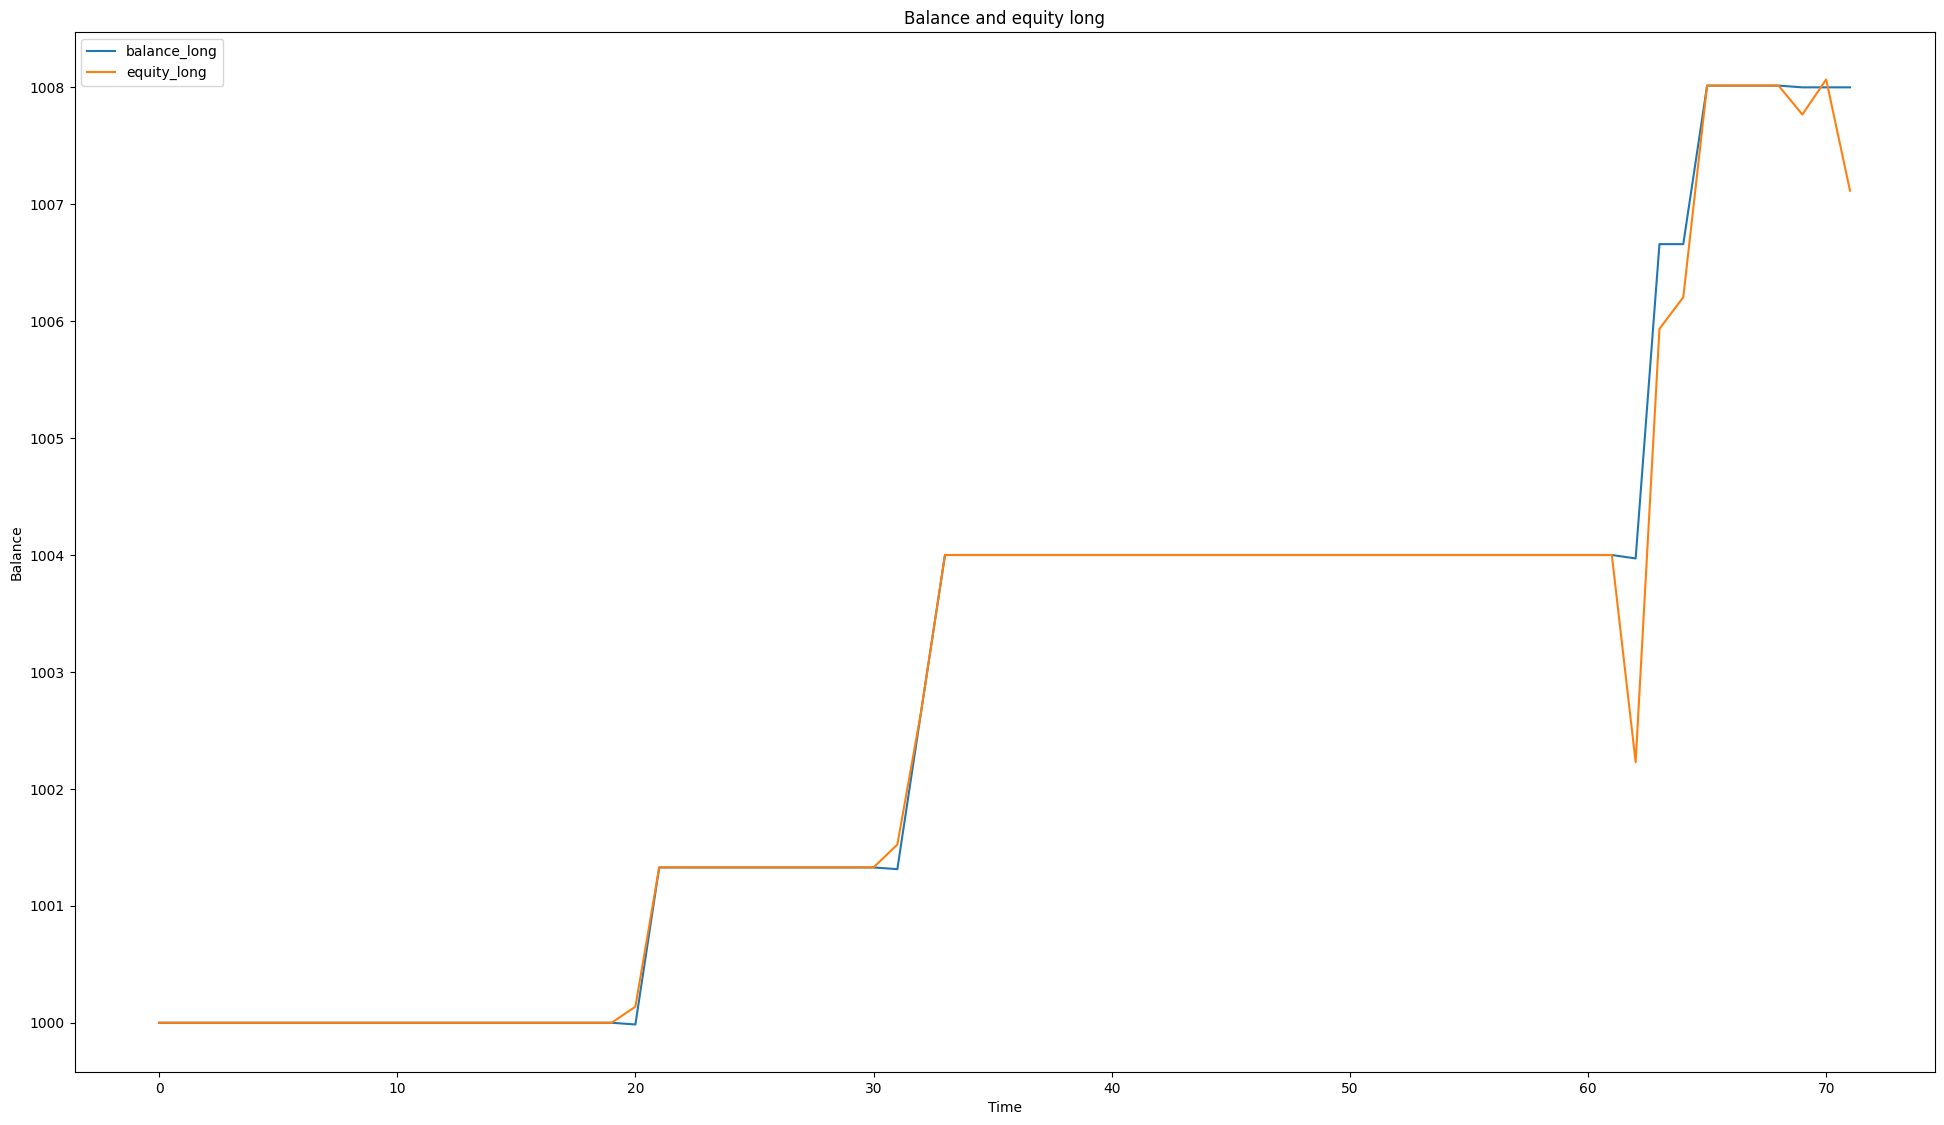

In [44]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")
plt.legend()

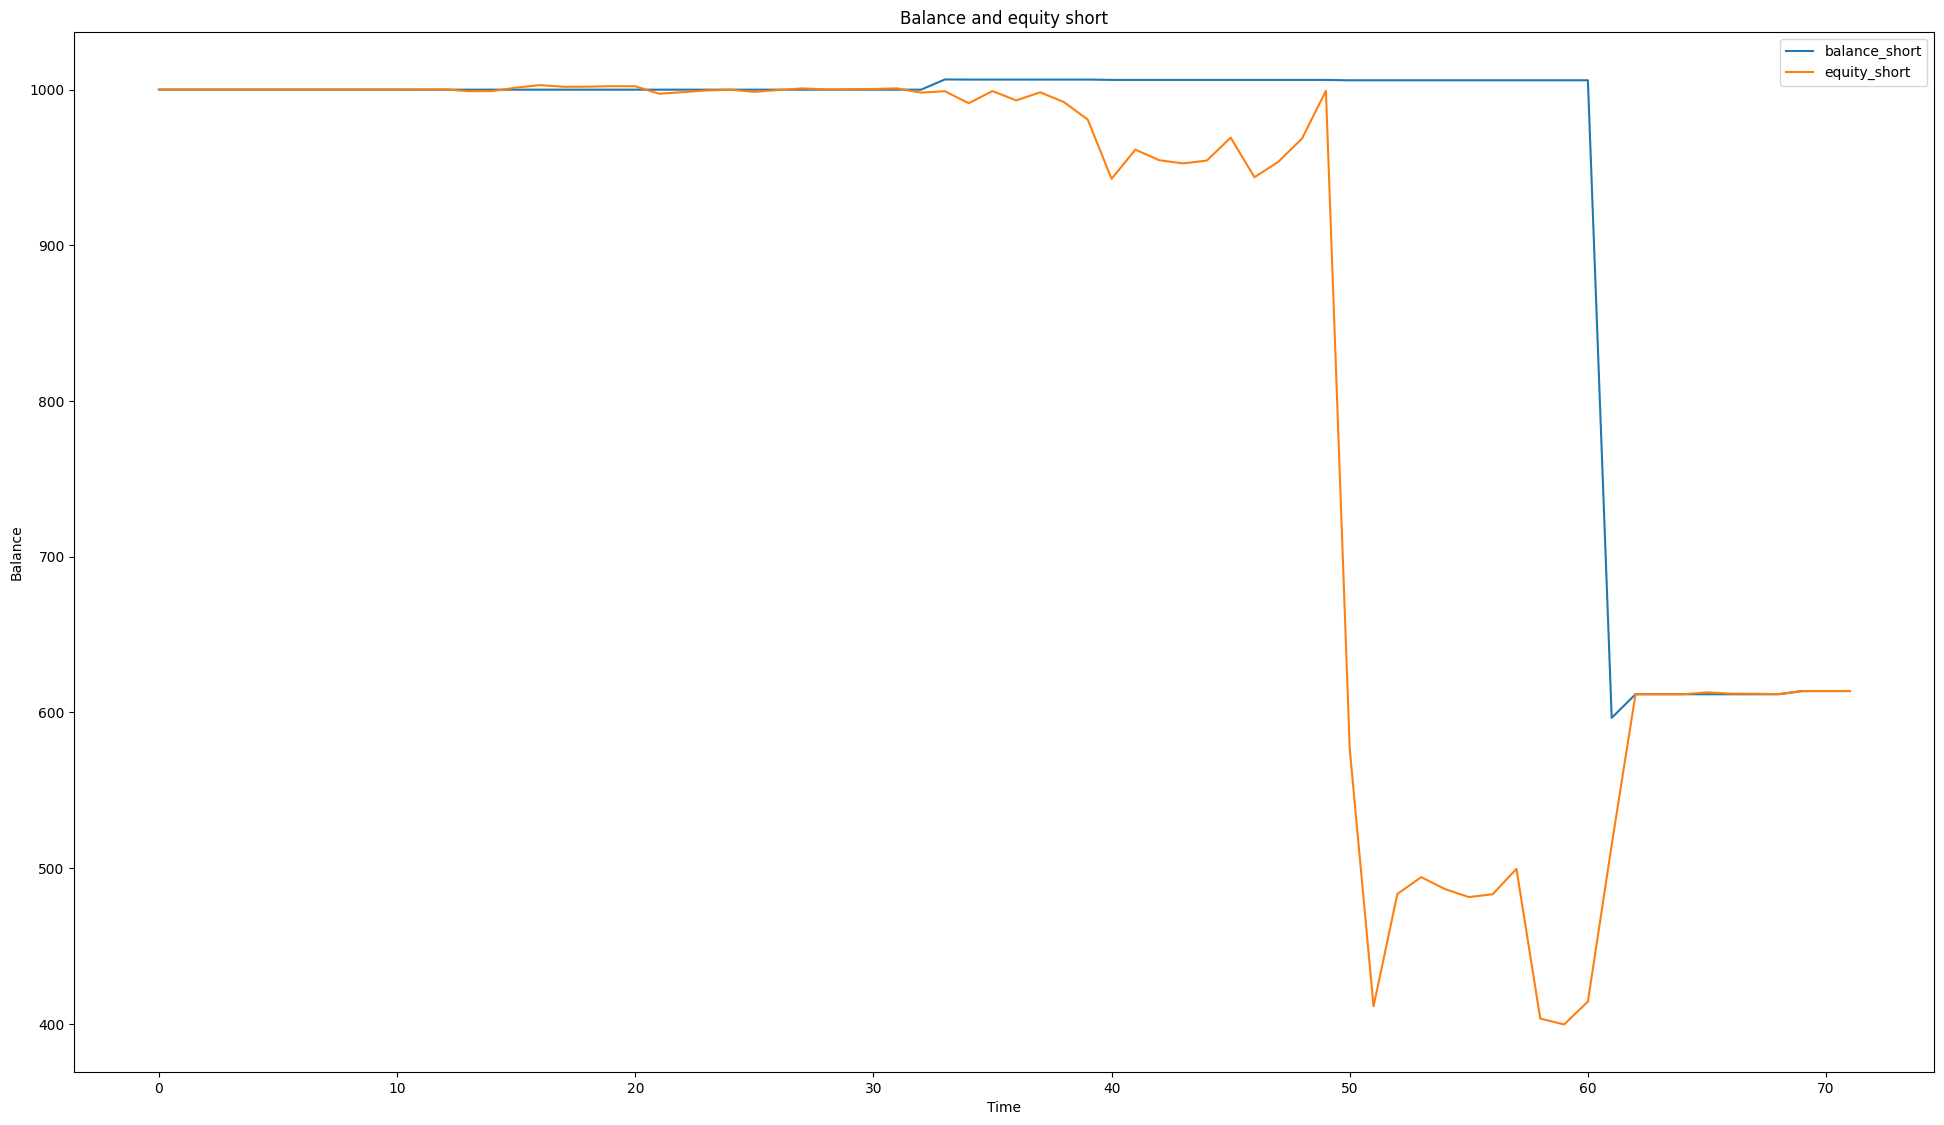

In [45]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")
plt.legend()

In [47]:
df

,price
timestamp,
2023-10-13 00:00:00,46.071
2023-10-13 00:01:00,46.026
2023-10-13 00:02:00,45.987
2023-10-13 00:03:00,45.990
2023-10-13 00:04:00,45.996
...,...
2023-10-15 23:55:00,57.628
2023-10-15 23:56:00,57.713
2023-10-15 23:57:00,57.743


12


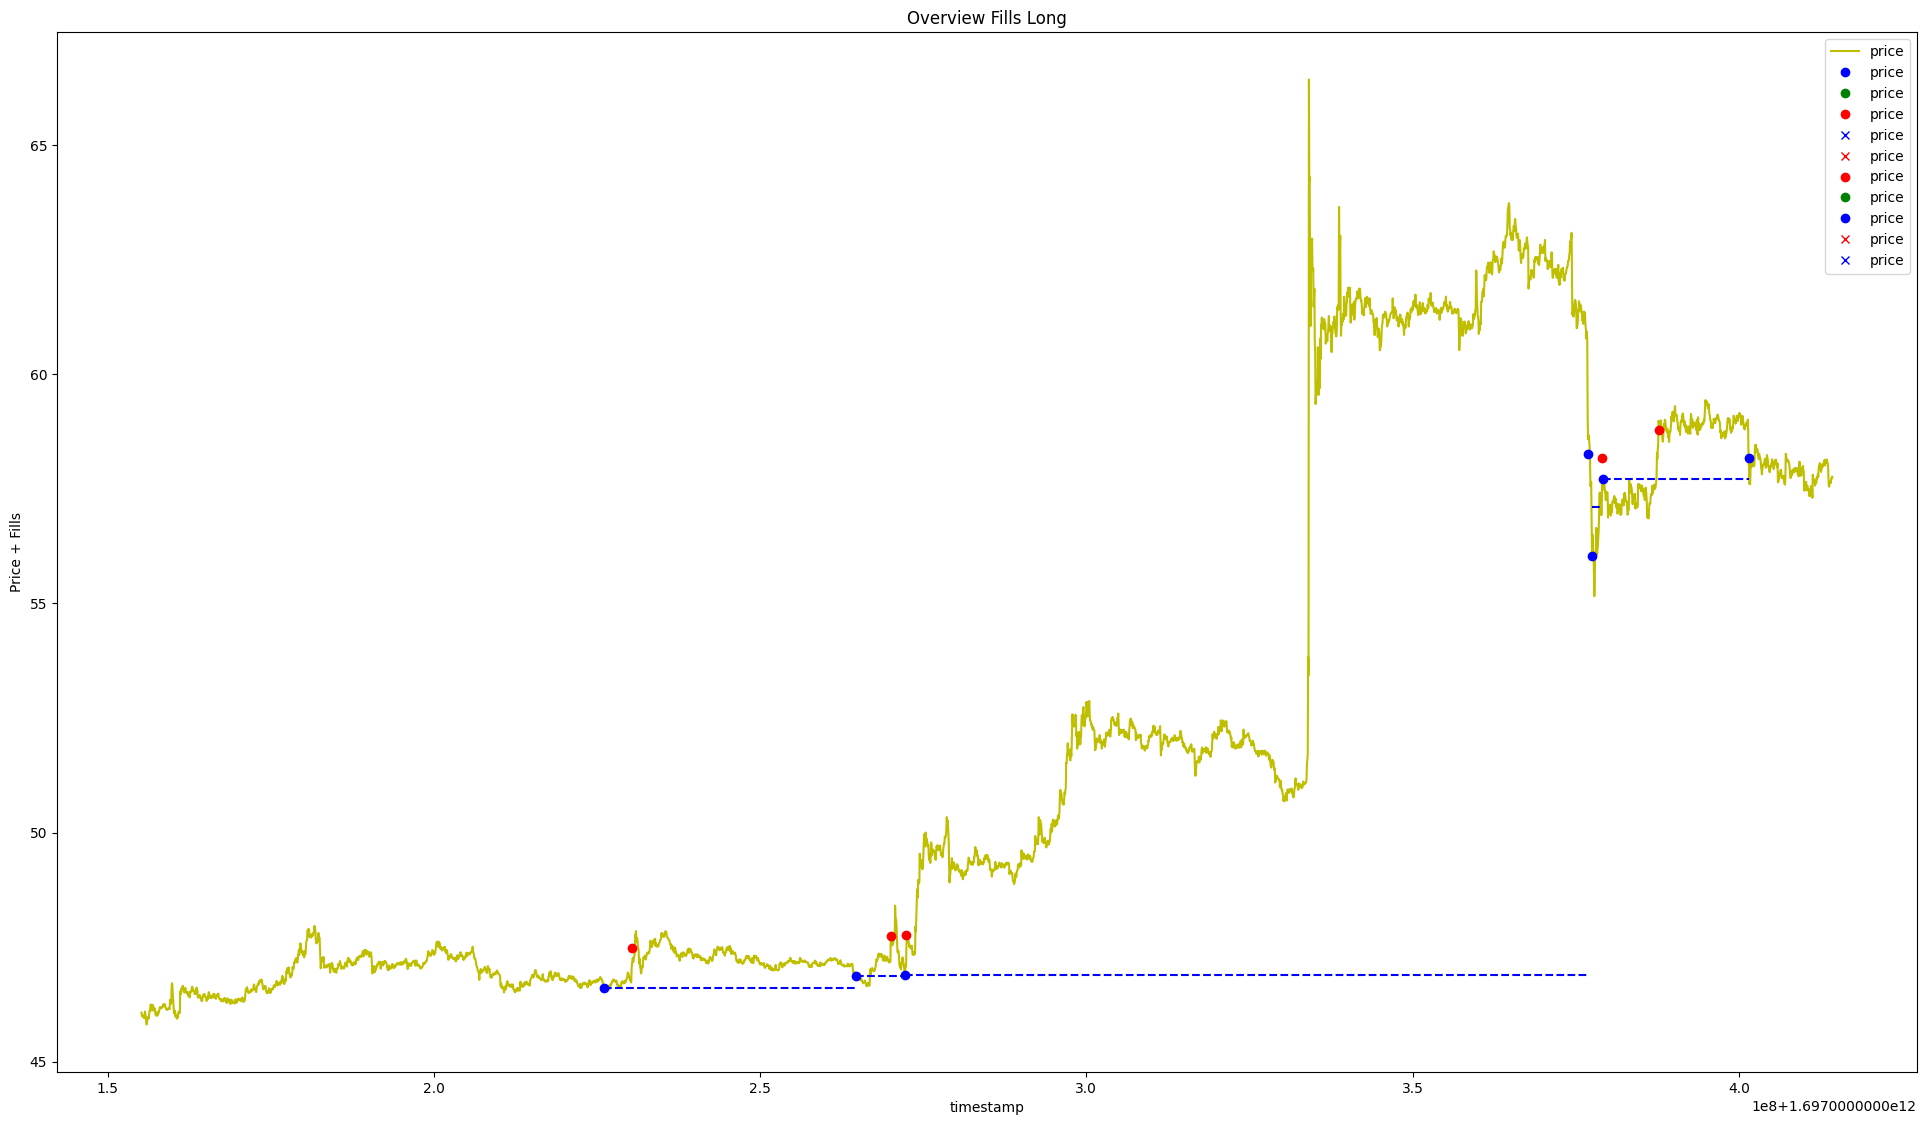

In [57]:
if len(longs) > 0:
    print(len(longs))
    plt.figure()
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")
    plt.legend()

21


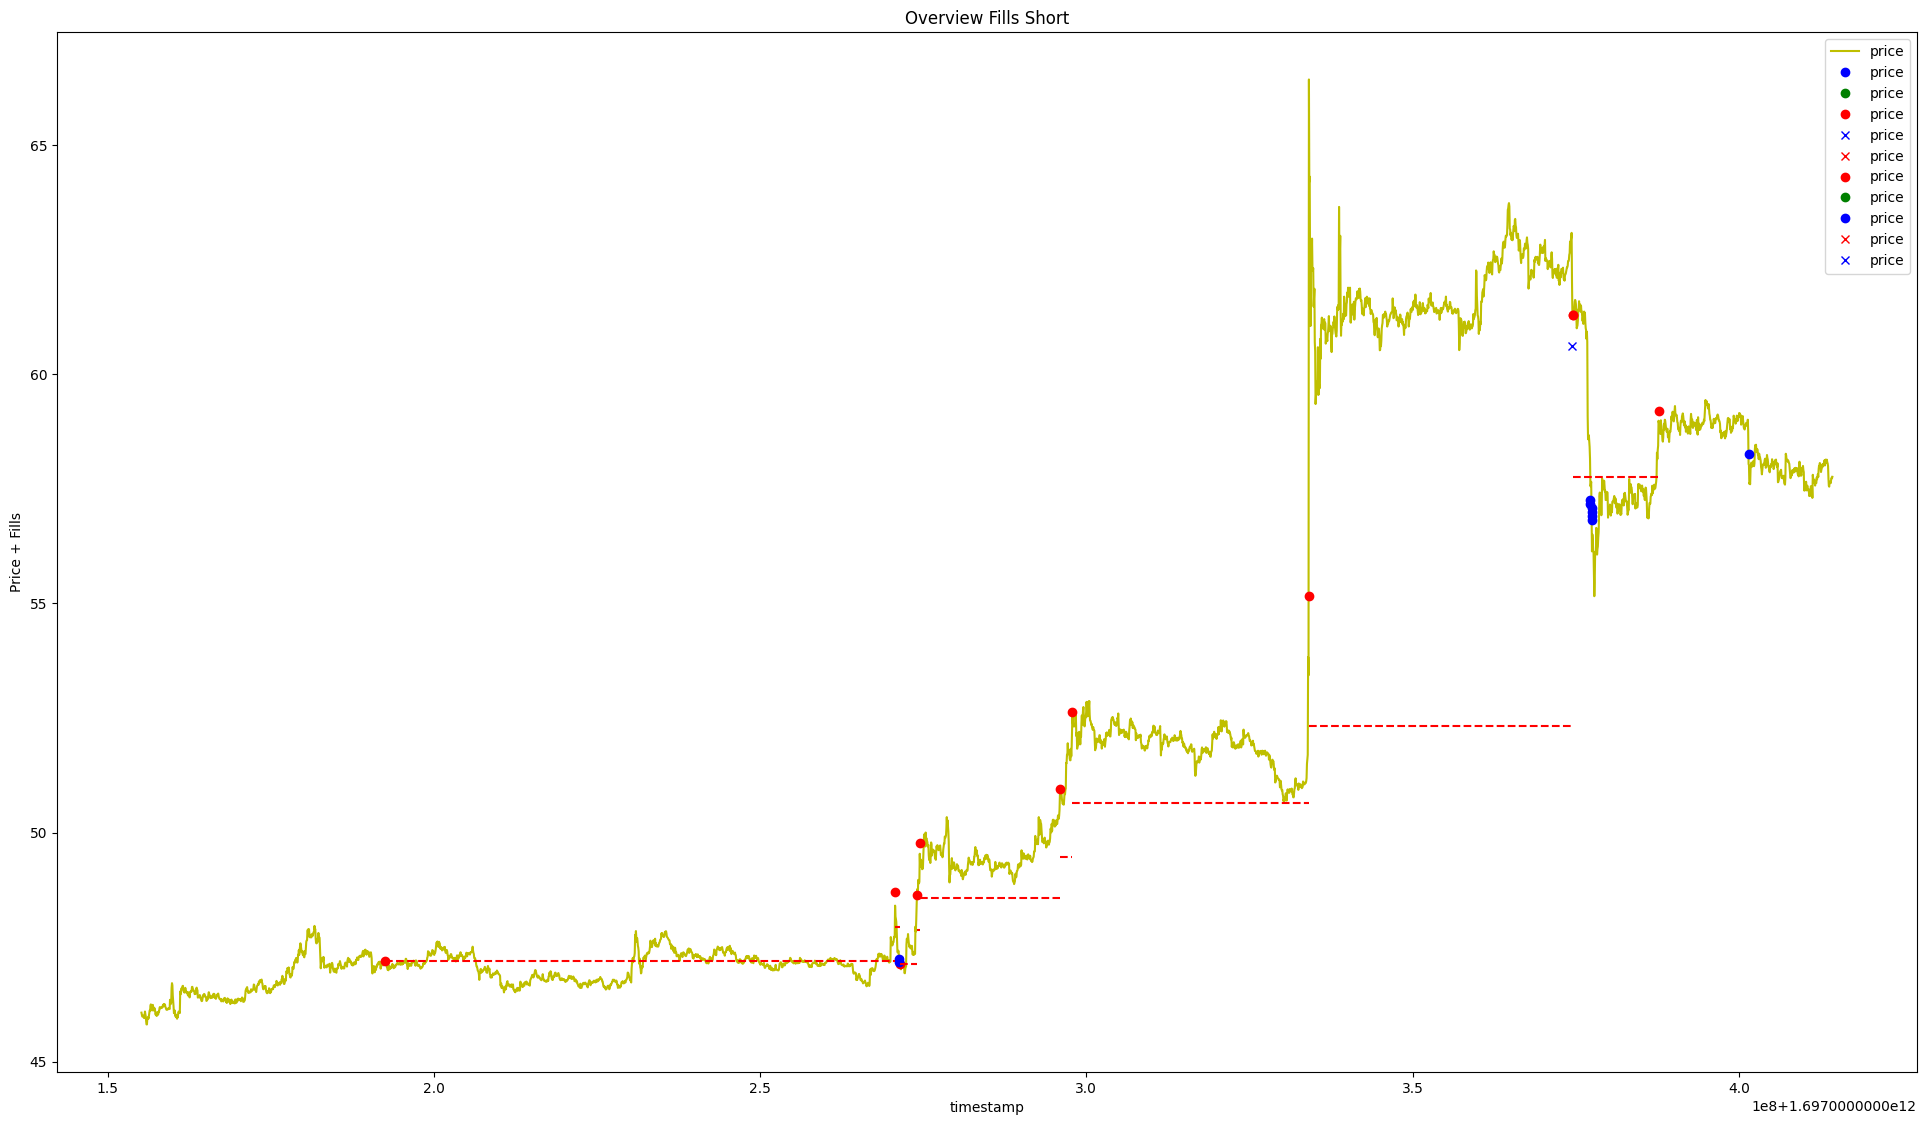

In [58]:
if len(shorts) > 0:
    print(len(shorts))
    plt.figure()
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")
    plt.legend()

<AxesSubplot:title={'center':'Wallet exposures'}, xlabel='Time', ylabel='Wallet Exposure'>

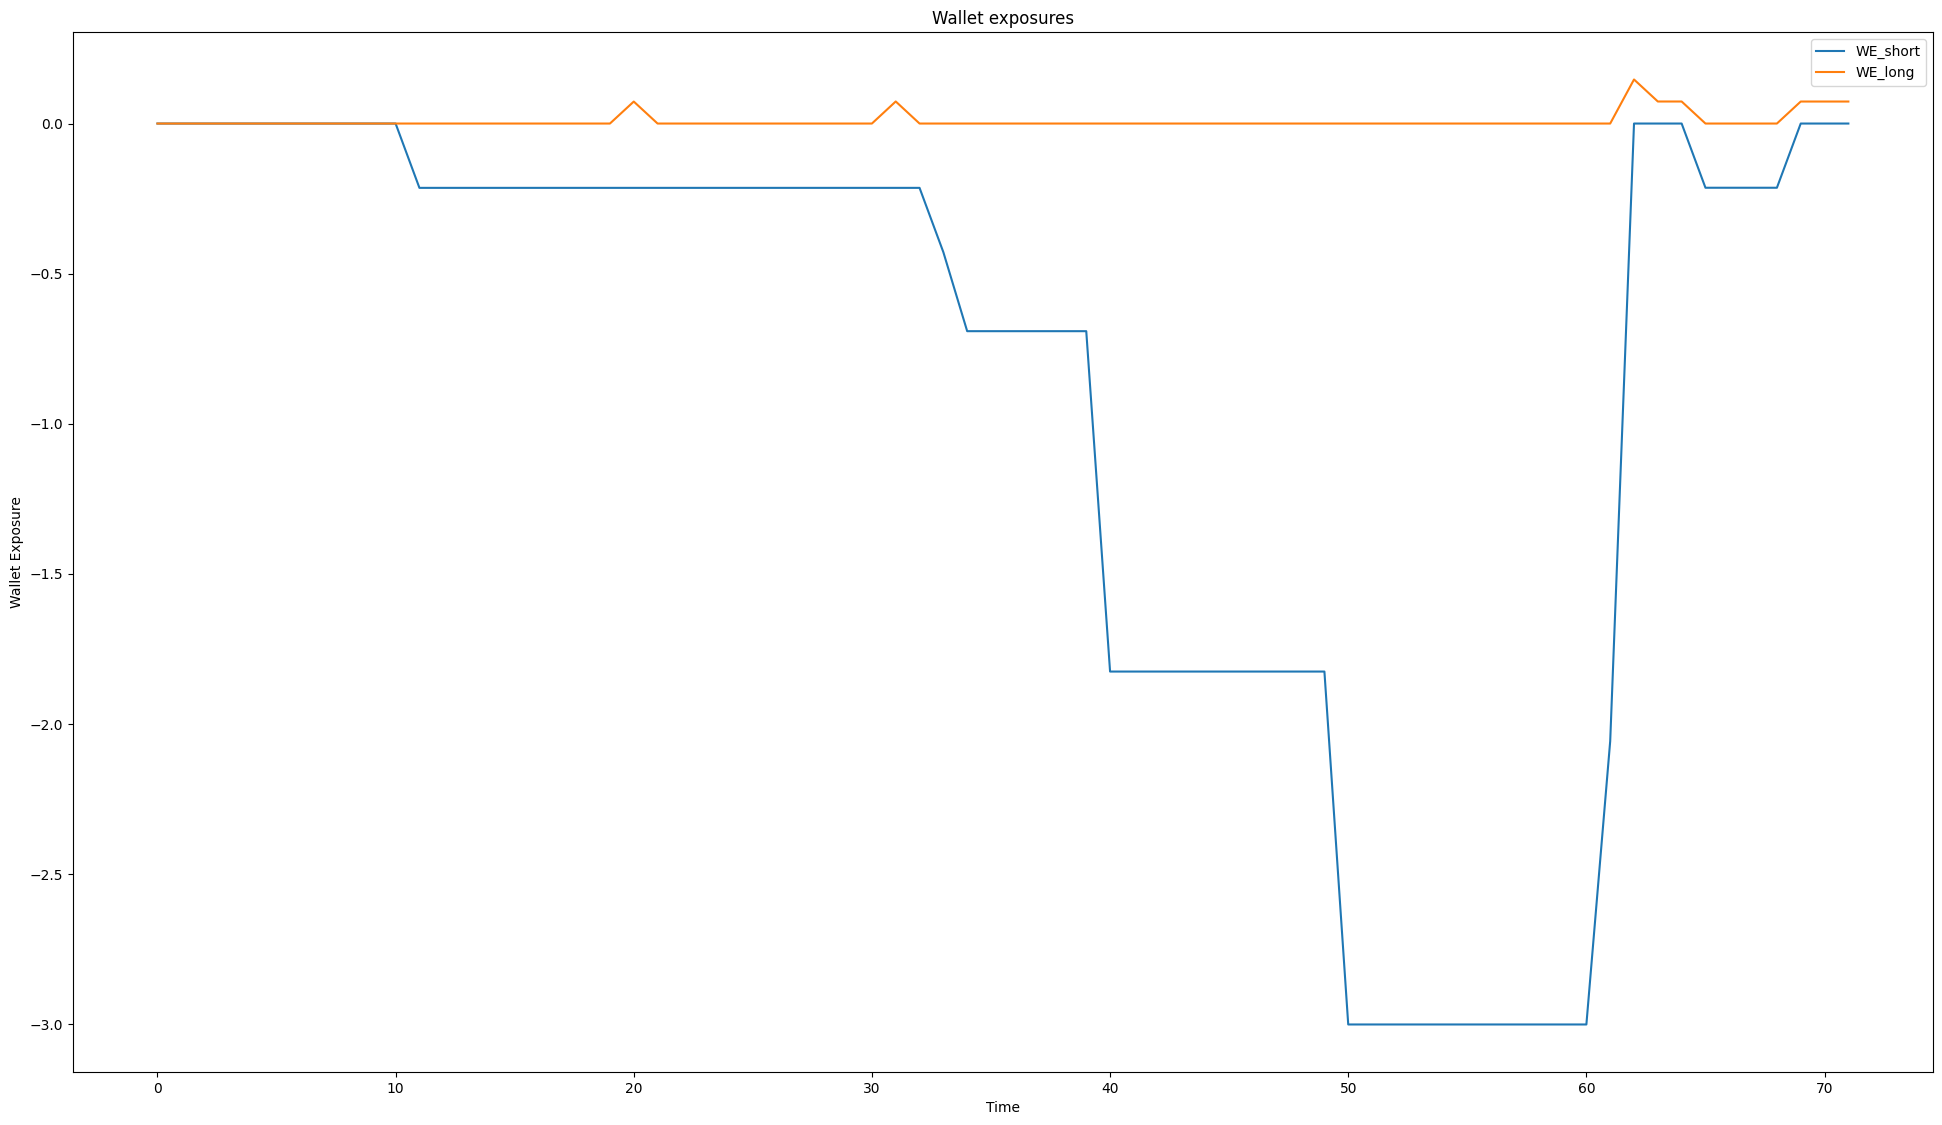

In [59]:
wes = pd.DataFrame(
    {"WE_short": (sdf.wallet_exposure_short.abs() * -1), "WE_long": sdf.wallet_exposure_long}
)
wes.plot(title="Wallet exposures", xlabel="Time", ylabel="Wallet Exposure")

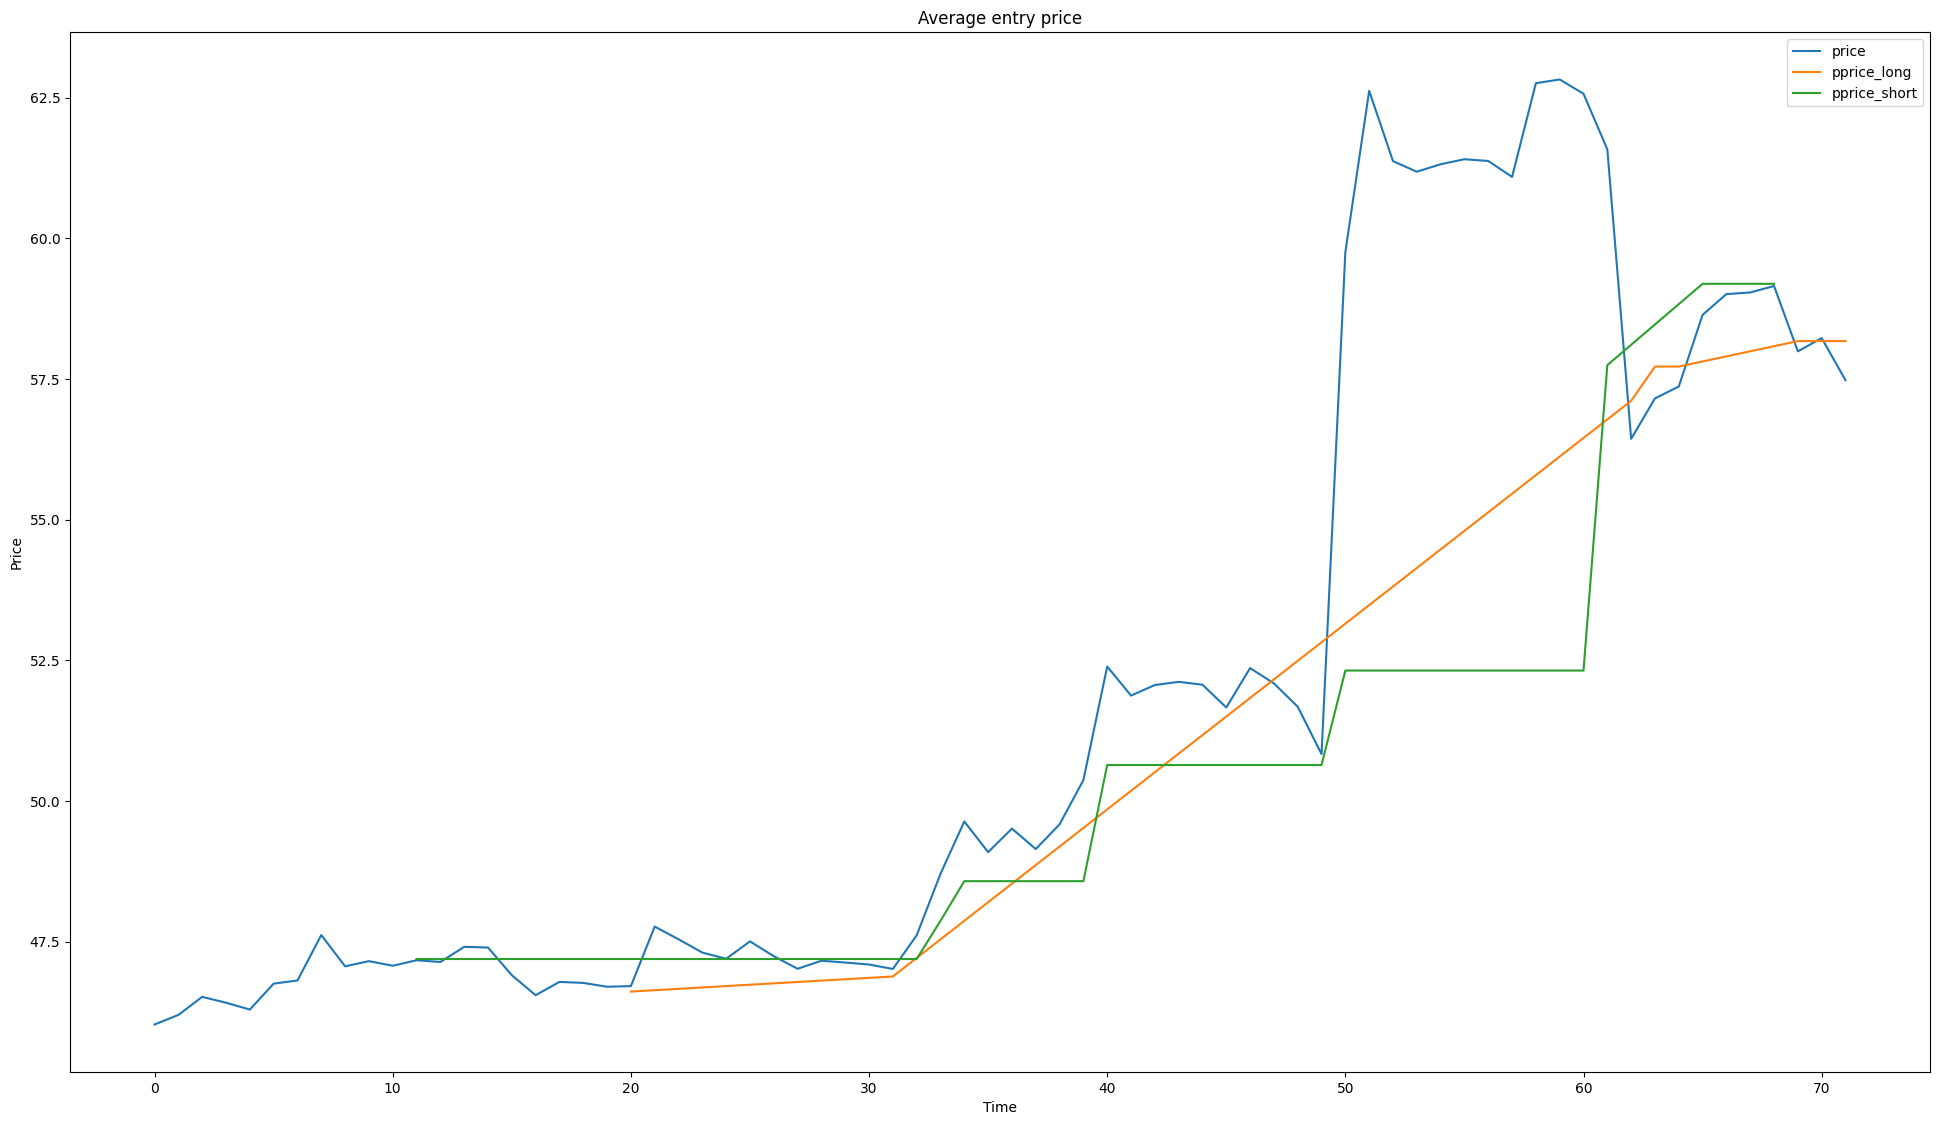

In [62]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf[sdf.psize_long != 0].pprice_long.replace(0.0, np.nan).plot()
sdf[sdf.psize_short != 0].pprice_short.replace(0.0, np.nan).plot()
plt.legend()

Mean price action distance long 0.006145 std 0.004588
Mean price action distance short -0.040776 std 0.057255


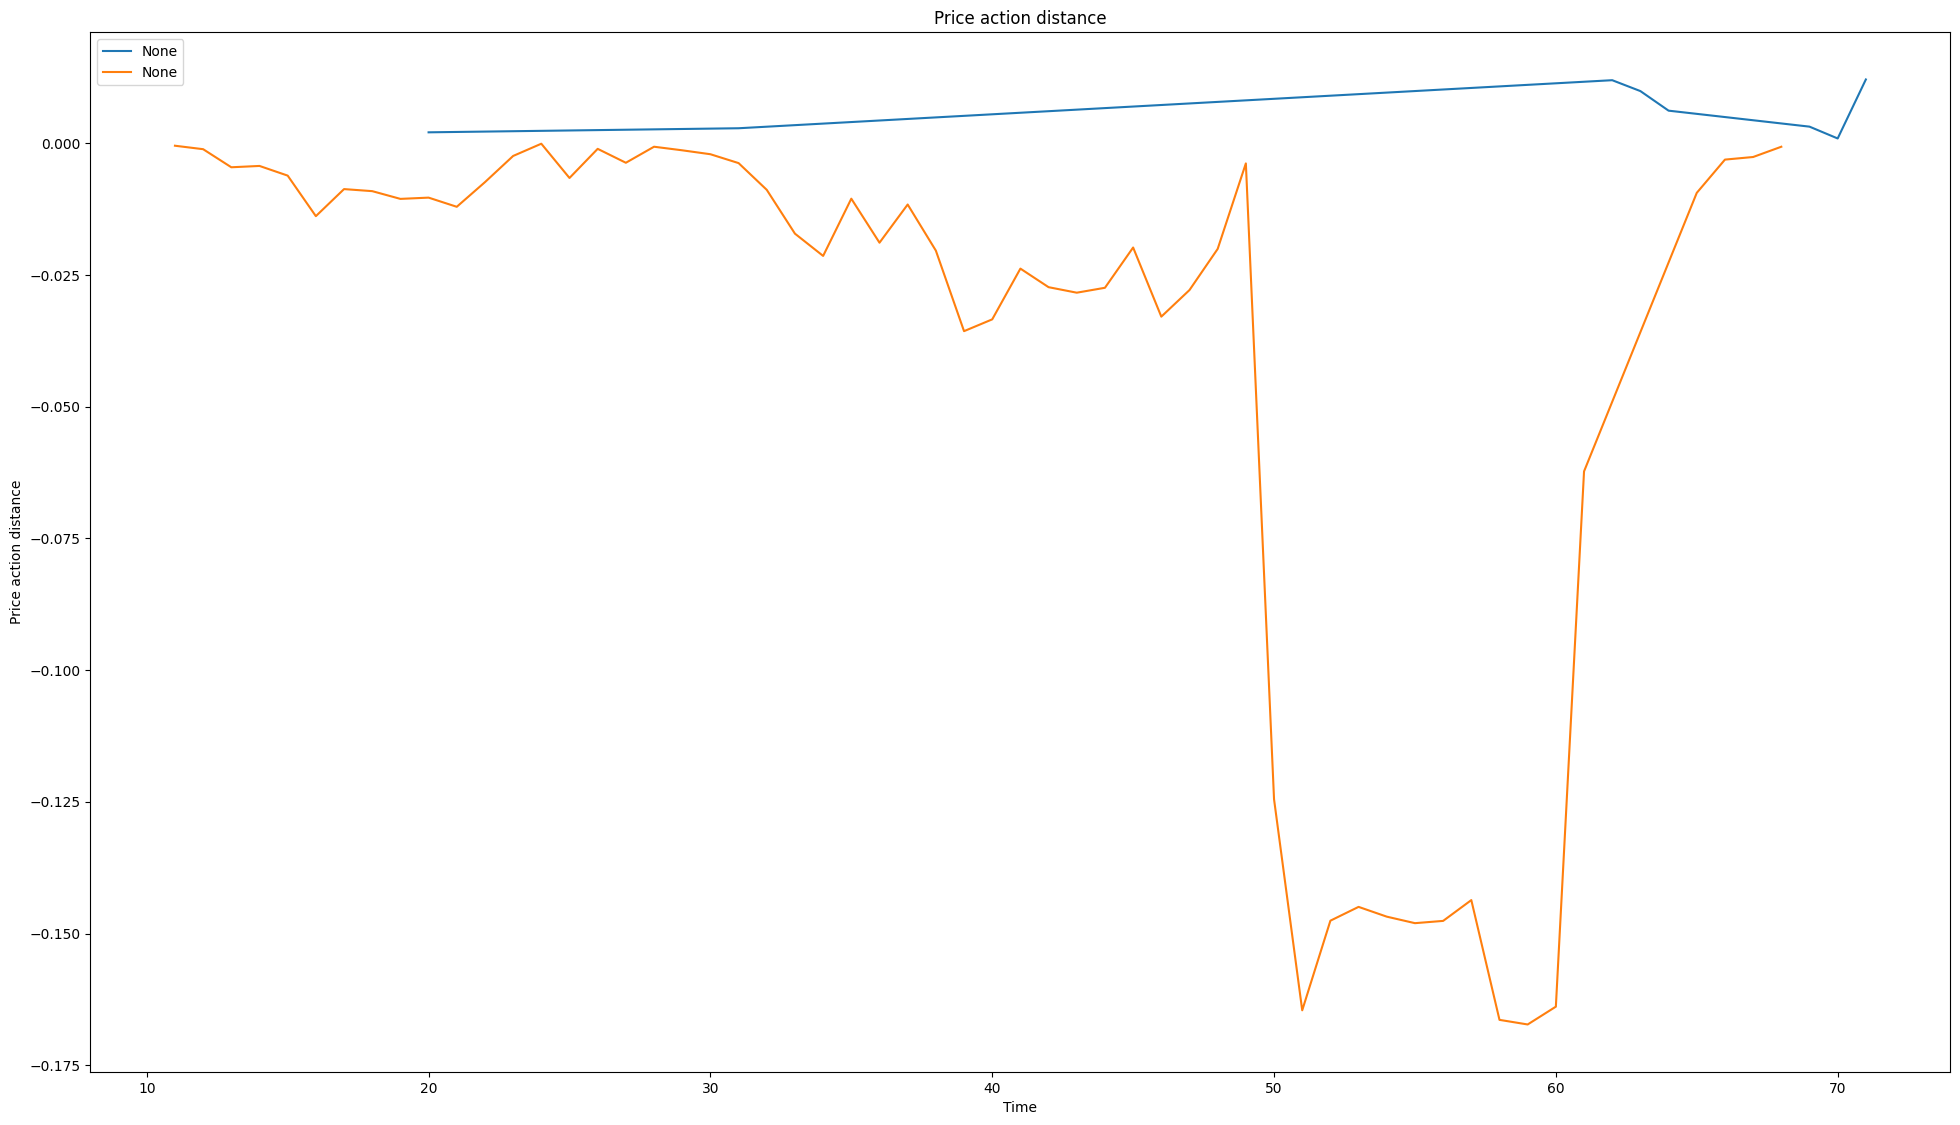

In [63]:
lpprices = sdf[sdf.psize_long != 0.0]
spprices = sdf[sdf.psize_short != 0.0]

PADistance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
PADistance_short = ((spprices.pprice_short - spprices.price).abs() / spprices.price) * -1
print(f"Mean price action distance long {PADistance_long.mean():.6f} std {PADistance_long.std():.6f}")
print(f"Mean price action distance short {PADistance_short.mean():.6f} std {PADistance_short.std():.6f}")

PADistance_long.plot()
PADistance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")
plt.legend()

spans in minutes [978.9440265702858, 1071.857640620316, 1173.5898790671702] n_days 3.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

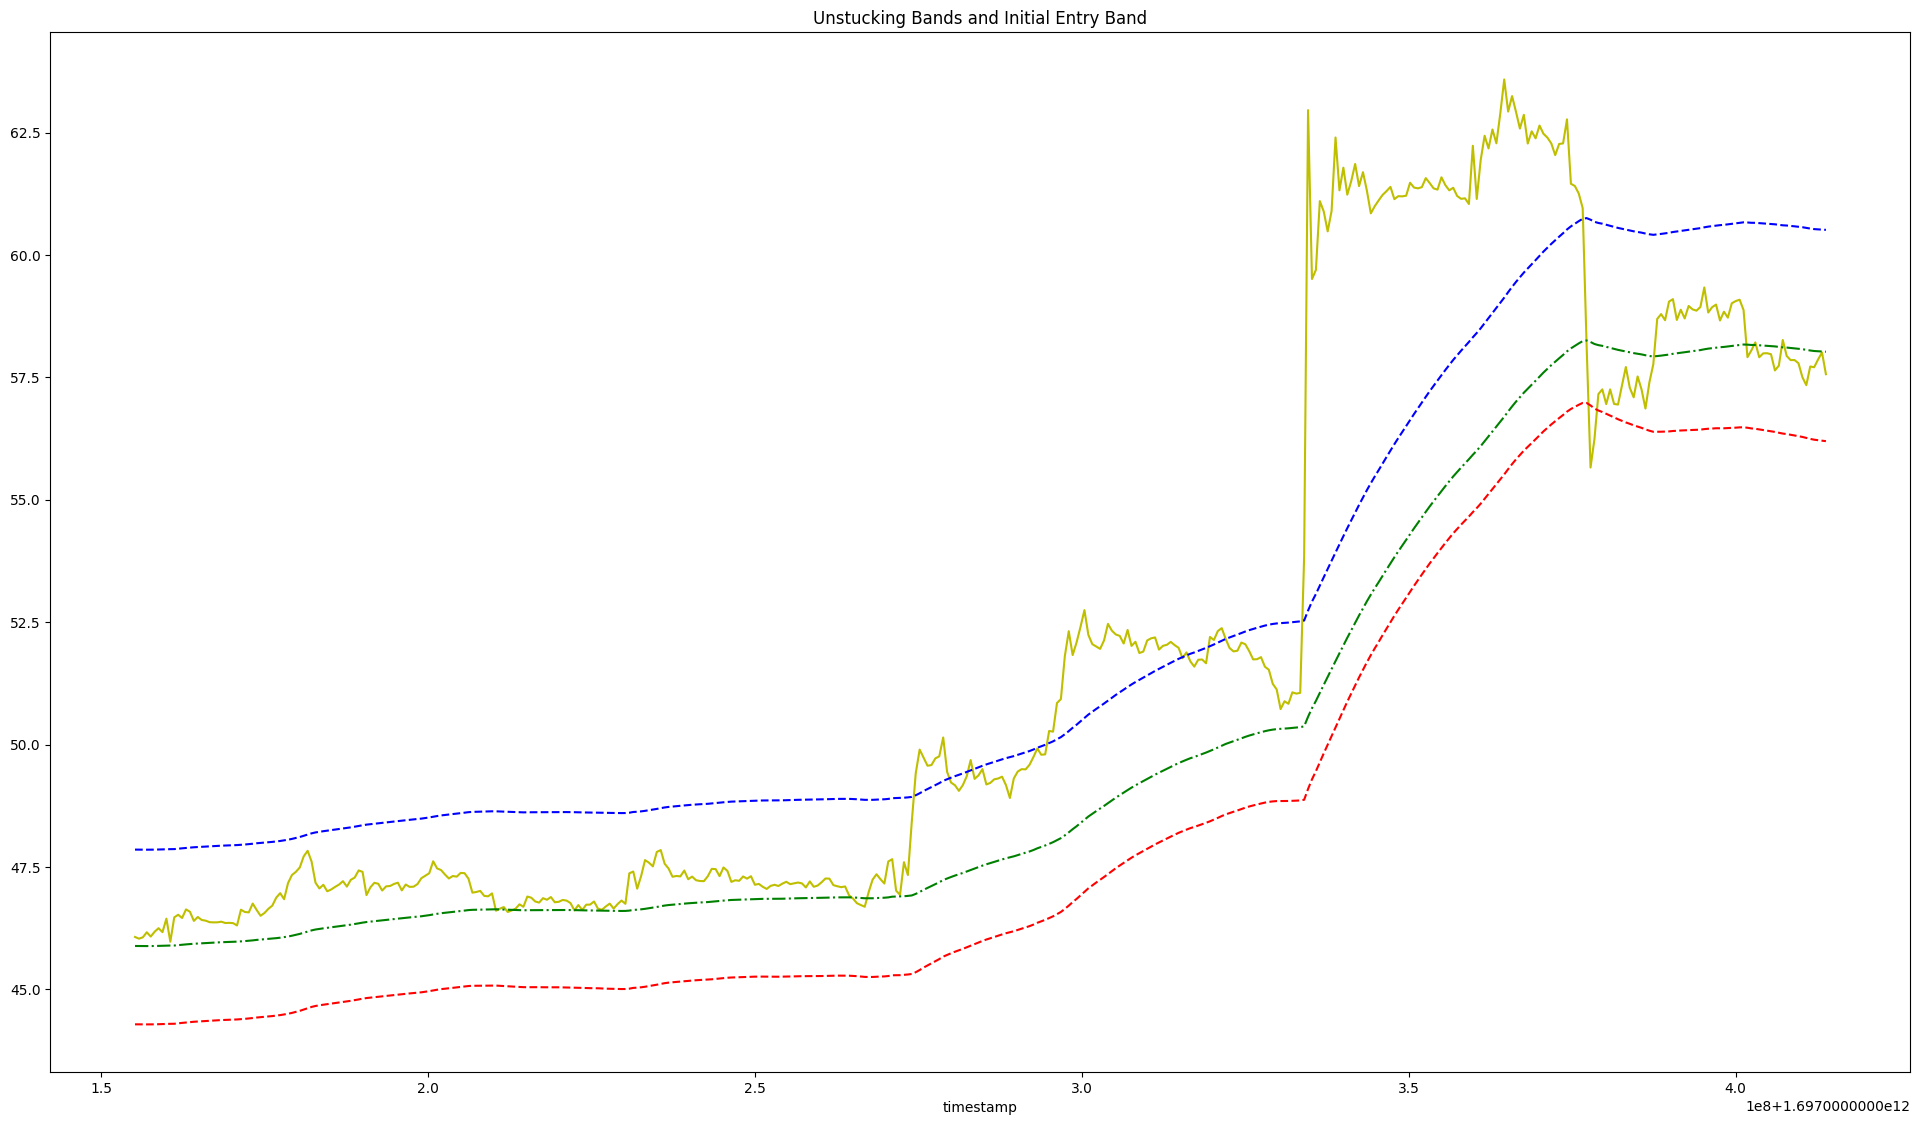

In [67]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
s = 10
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::s].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::s].plot(
    style="b--",
)
unstucking_band_upper.iloc[::s].plot(style="r--")
long_ientry_band.iloc[::s].plot(style="g-.")

spans in minutes [465.9268827189821, 538.8377248909859, 623.1580630663296] n_days 3.0


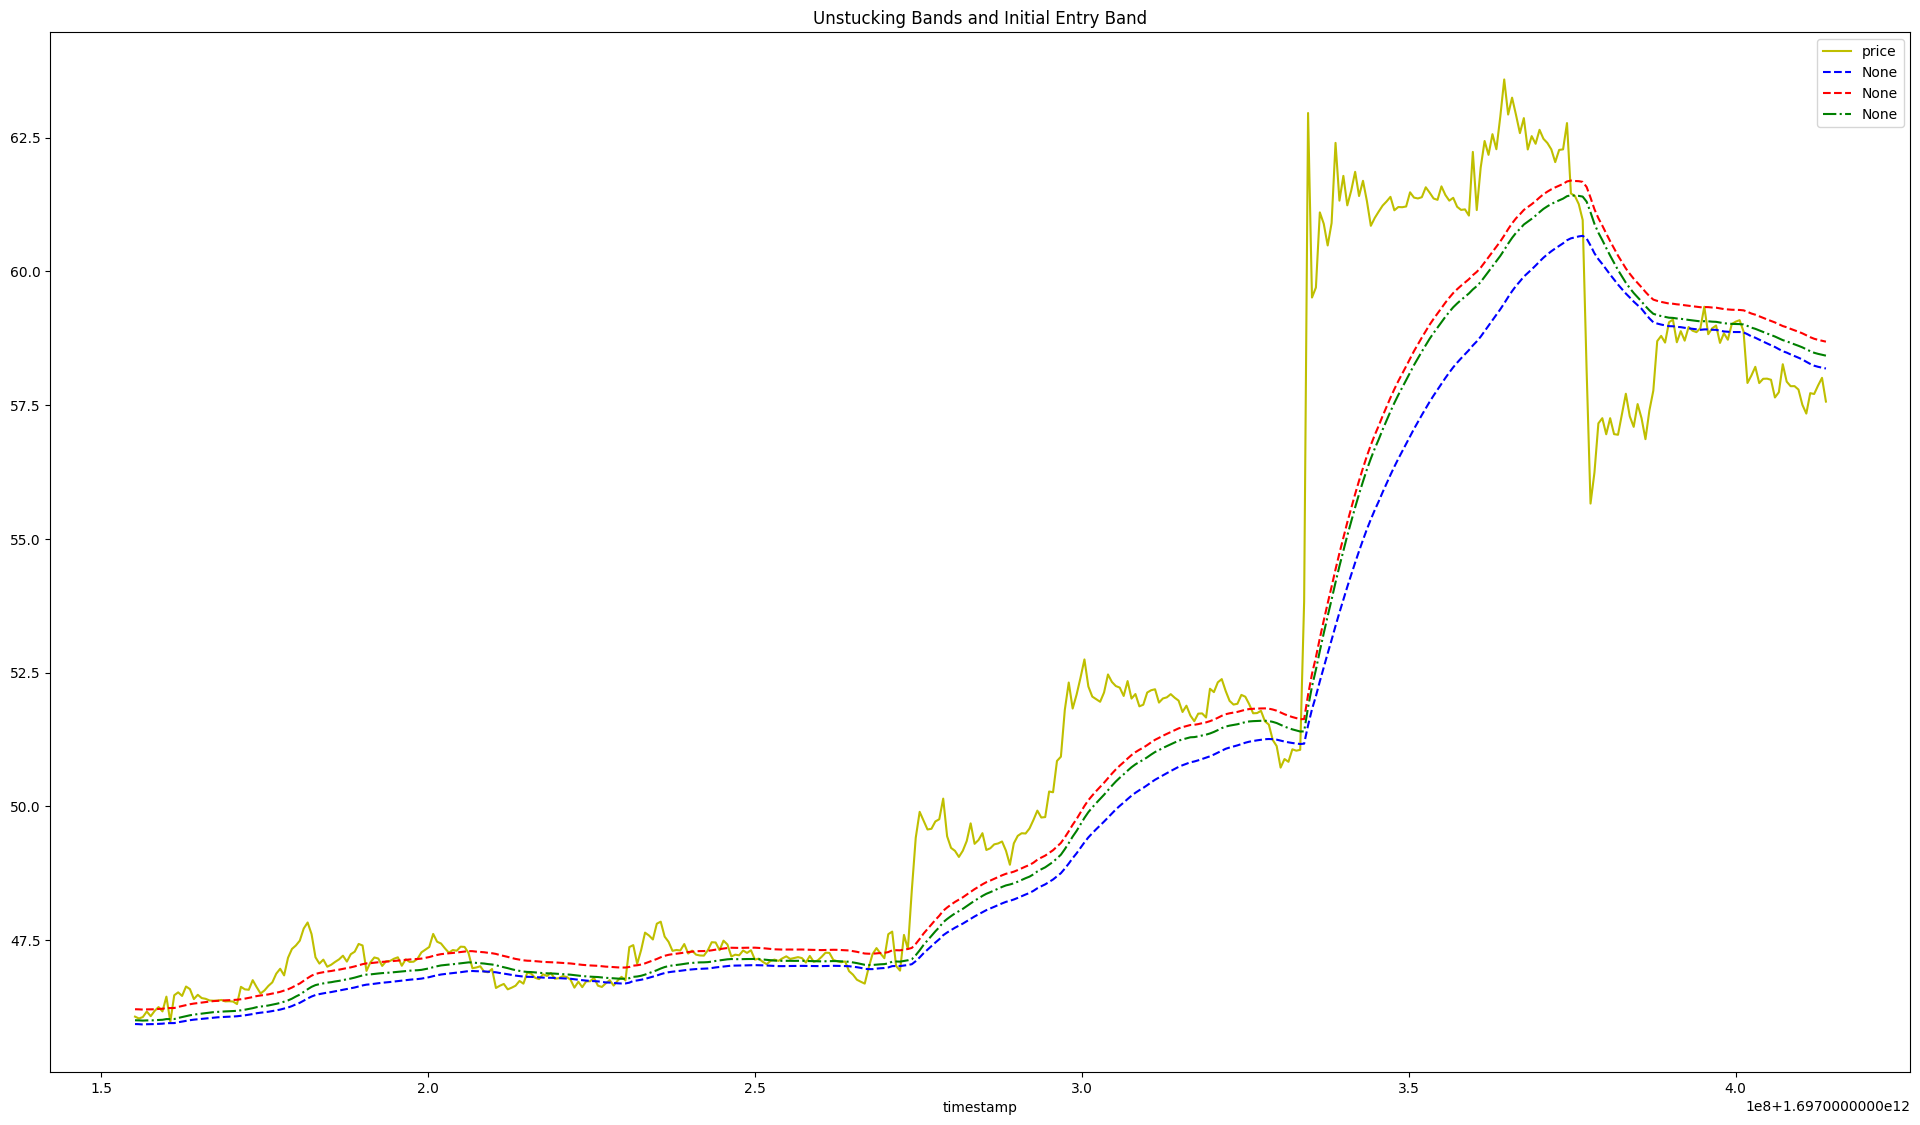

In [69]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
s = 10
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::s].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::s].plot(style="b--")
unstucking_band_upper.iloc[::s].plot(style="r--")
short_ientry_band.iloc[::s].plot(style="g-.")
plt.legend()